In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Get the data
In this notebook we face a regression problem: predicting the cost of a house in California. The dataset used is the `california_housing`, it consists of 20640 records with 8 numerical features:
```
features_name = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',
                 'Population', 'AveOccup', 'Latitude', 'Longitude']
```

In [14]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

In [15]:
x_full, y_full = fetch_california_housing(return_X_y=True)
y_full = y_full.reshape((-1,1))
print(x_full.shape, y_full.shape)
x_train, x_test, y_train, y_test = train_test_split(x_full, y_full)
x_train, x_val,  y_train, y_val  = train_test_split(x_train, y_train)

(20640, 8) (20640, 1)


In [17]:
print(x_train[0])

from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)
x_train, x_test, x_val = [scaler.transform(x_) for x_ in (x_train, x_test, x_val)]

print(x_train[0])

[ 4.03790000e+00  3.40000000e+01  5.27586207e+00  9.60591133e-01
  1.30500000e+03  3.21428571e+00  3.39800000e+01 -1.18050000e+02]
[ 0.09089928  0.42697496 -0.05738321 -0.30800086 -0.11392645  0.03229162
 -0.77935468  0.76626053]


# Wide and Deep
The following is a simplified version. The original one (described in [this paper](https://arxiv.org/pdf/1606.07792.pdf)) was designed for regression and classification problems with sparse inputs, in particular for recommender systems. The idea is to achieve both memorization (learning of the correlation available in the historical data) and generalization (exploring new feature combinations that have never or rarely occurred in the past) by combining together wide and deep models.
### Define the model

In [11]:
from tensorflow.keras.layers import Input, Dense, Concatenate

# This is not a real network - this is just to generate the picture
inputs  = Input(shape=[x_train.shape[1]])
hidden1 = Dense(20, activation="relu")(inputs)
hidden2 = Dense(10, activation="relu")(hidden1)
hidden3 = Dense(10, activation="relu")(hidden2)
concat  = Concatenate()([hidden1, hidden3])
outputs = Dense(1, activation=None)(concat)

wide_dp = tf.keras.Model(inputs=[inputs], outputs=outputs)

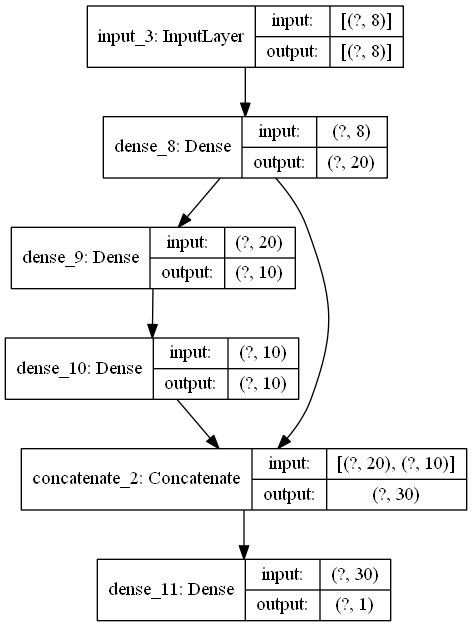

In [12]:
tf.keras.utils.plot_model(wide_dp, show_shapes=True)

### Training

In [13]:
wide_dp.compile(loss='mse', optimizer='sgd')
history = wide_dp.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 62us/sample - loss: 0.6890 - val_loss: 0.4625
Epoch 2/20
11610/11610 [==============================] - 0s 35us/sample - loss: 0.5327 - val_loss: 0.4496
Epoch 3/20
11610/11610 [==============================] - 0s 34us/sample - loss: 0.4887 - val_loss: 0.4106
Epoch 4/20
11610/11610 [==============================] - 0s 35us/sample - loss: 0.4170 - val_loss: 0.3977
Epoch 5/20
11610/11610 [==============================] - 0s 35us/sample - loss: 0.4046 - val_loss: 0.3980
Epoch 6/20
11610/11610 [==============================] - 0s 32us/sample - loss: 0.3880 - val_loss: 0.3760
Epoch 7/20
11610/11610 [==============================] - 0s 31us/sample - loss: 0.3874 - val_loss: 0.3757
Epoch 8/20
11610/11610 [==============================] - 0s 33us/sample - loss: 0.3846 - val_loss: 0.3855
Epoch 9/20
11610/11610 [==============================] - 0s 31us/sample - loss: 0.3779 - val_l

Text(0.5, 0, 'Epoch')

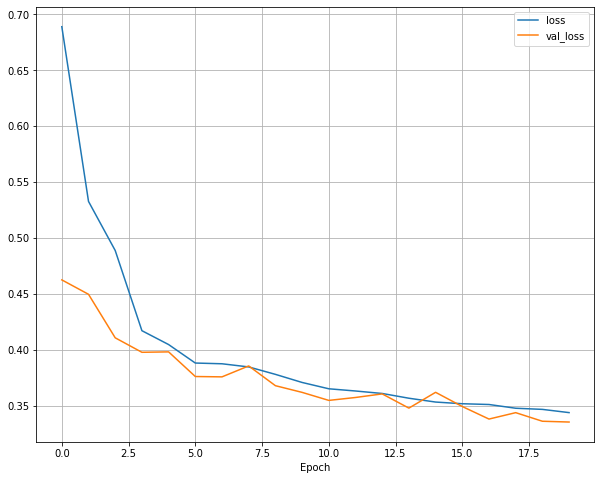

In [18]:
plt.figure(figsize=(10,8))
for k, v in history.history.items():
    plt.plot(v, label=k)
plt.legend()
plt.grid()
plt.xlabel('Epoch')

### Evaluation

In [19]:
test_loss = wide_dp.evaluate(x_test, y_test)
print("Test loss    : %.3f"%test_loss)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test loss    : 0.326


# Multiple Inputs
Suppose to have better insights into the data and to know that some features present simple patterns while other need more complex transformations. We can split the inputs and create two different paths.

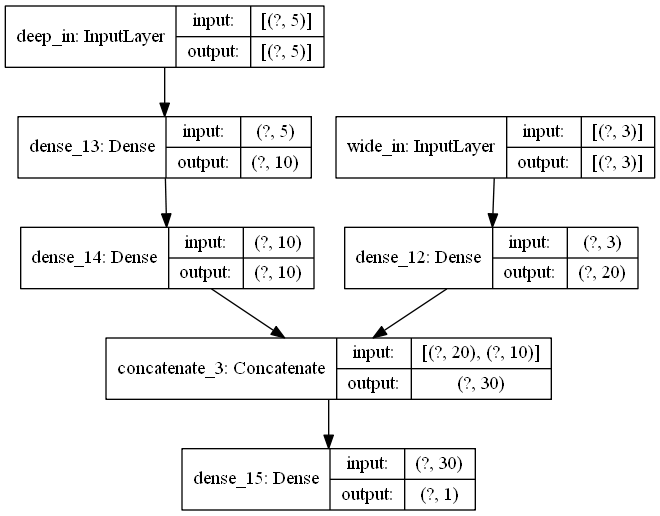

In [20]:
from tensorflow.keras.layers import Input, Dense, Concatenate

wide_feats = 3

inputs_w = Input(shape=[wide_feats], name='wide_in')
inputs_d = Input(shape=[x_train.shape[1] - wide_feats], name='deep_in')
hidden1 = Dense(20, activation="relu")(inputs_w)
hidden2 = Dense(10, activation="relu")(inputs_d)
hidden3 = Dense(10, activation="relu")(hidden2)
concat  = Concatenate()([hidden1, hidden3])
outputs = Dense(1, activation=None)(concat)

multi_input = tf.keras.Model(inputs=[inputs_w, inputs_d], outputs=outputs)
tf.keras.utils.plot_model(multi_input, show_shapes=True)

In [21]:
multi_input.compile(loss='mse', optimizer='sgd')
history = multi_input.fit(x={'wide_in': x_train[:,:wide_feats], 'deep_in': x_train[:,wide_feats:]},
                          y=y_train,
                          epochs=30,
                          validation_data=((x_val[:,:wide_feats], x_val[:,wide_feats:]), y_val))

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11610/11610 [==============================] - 1s 76us/sample - loss: 0.8649 - val_loss: 0.6630
Epoch 2/30
11610/11610 [==============================] - 0s 37us/sample - loss: 0.5524 - val_loss: 0.5496
Epoch 3/30
11610/11610 [==============================] - 0s 40us/sample - loss: 0.4692 - val_loss: 0.4994
Epoch 4/30
11610/11610 [==============================] - 0s 38us/sample - loss: 0.4385 - val_loss: 0.4739
Epoch 5/30
11610/11610 [==============================] - 0s 37us/sample - loss: 0.4234 - val_loss: 0.4582
Epoch 6/30
11610/11610 [==============================] - 0s 37us/sample - loss: 0.4126 - val_loss: 0.4479
Epoch 7/30
11610/11610 [==============================] - 0s 36us/sample - loss: 0.4049 - val_loss: 0.4466
Epoch 8/30
11610/11610 [==============================] - 0s 37us/sample - loss: 0.3973 - val_loss: 0.4449
Epoch 9/30
11610/11610 [==============================] - 0s 36us/sample - loss: 0.3943 - val_l

Text(0.5, 0, 'Epoch')

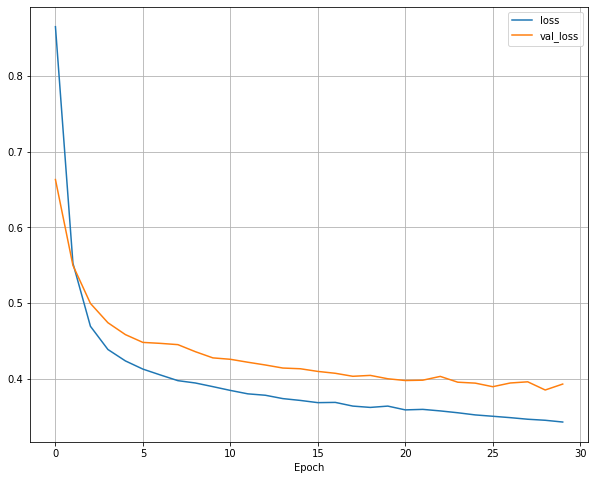

In [22]:
plt.figure(figsize=(10,8))
for k, v in history.history.items():
    plt.plot(v, label=k)
plt.legend()
plt.grid()
plt.xlabel('Epoch')

### Evaluation

In [23]:
test_loss = multi_input.evaluate({'wide_in':x_test[:,:wide_feats], 'deep_in':x_test[:,wide_feats:]}, y_test)
print("Test loss    : %.3f"%test_loss)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test loss    : 0.342


### Predictions

In [24]:
multi_input({'deep_in':x_val[:,wide_feats:], 'wide_in':x_val[:,:wide_feats]})


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



InvalidArgumentError: Matrix size-incompatible: In[0]: [3870,3], In[1]: [5,10] [Op:MatMul]